### 모델 불러오기

In [1]:
from keras.models import load_model

model_path = 'D:/OCT Project/OCT-Image/이진분류기/두번째 모델/'
model = load_model(model_path + 'normal_binary.h5')
model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 299, 299, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 299, 299, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 149, 149, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 149, 149, 64)      18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 149, 149, 64)      256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 74, 74, 64)       

### 개별 이미지 전처리

In [2]:
img_path = "D:/OCT Project/OCT-Image/이진분류기/NORMAL_BINARY/test/NORMAL/NORMAL-1753482-1.jpeg"

from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, color_mode="grayscale", target_size=(299,299)) # (img_path, color, size)
img_tensor = image.img_to_array(img) # 텐서 생성
img_tensor = np.expand_dims(img_tensor, axis=0) # 이미지를 4D텐서로 변경 
img_tensor /= 255. # 모델이 훈련될 때와 동일한 전처리 이미지에 적용

print(img_tensor.shape)

(1, 299, 299, 1)


### 테스트 사진 출력

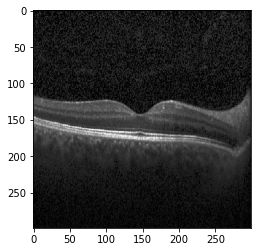

In [3]:
import matplotlib.pyplot as plt
"""
(M, N): an image with scalar data. The values are mapped to colors using normalization and a colormap. See parameters norm, cmap, vmin, vmax.
(M, N, 3): an image with RGB values (0-1 float or 0-255 int).
(M, N, 4): an image with RGBA values (0-1 float or 0-255 int), i.e. including transparency.
"""
img = np.reshape(img_tensor, (299,299)) # matplotlib에서는 gray를 출력하기 위해 (n,n)으로 표현해줘야 한다.
plt.imshow(img, cmap='gray')
plt.show()

### 입력텐서와 출력텐서의 리스트로 모델 객체 만들기

In [4]:
from keras import models

layer_outputs = [layer.output for layer in model.layers[:8]] # 상위 8개의 layer를 출력
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) # 입력에 대해 8개의 층의 출력을 반환하는 모델을 생성

### 예측모드로 모델 실행하기 / 채널 시각화

(1, 299, 299, 32)


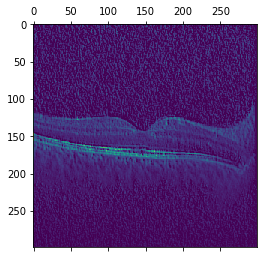

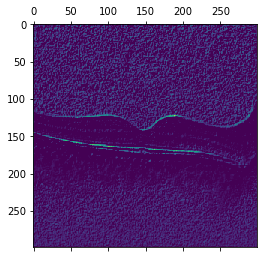

In [18]:
activations = activation_model.predict(img_tensor)

first_layer_activation = activations[0] # 첫번째 layer에 대한 활성화값
print(first_layer_activation.shape) # 첫번재 layer에서 32개의 채널을 가진 (299,299)사이즈의 특성 맵

import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0,:,:,17], cmap='viridis') # 첫번재 layer에서의 18번재 채널
plt.matshow(first_layer_activation[0,:,:,20], cmap='viridis') # 첫번재 layer에서의 21번재 채널

### 중간층의 모든 활성화에 있는 채널 시각화하기

In [29]:
for i in range(8):
    print(activations[i].shape)

(1, 299, 299, 32)
(1, 299, 299, 32)
(1, 149, 149, 32)
(1, 149, 149, 32)
(1, 149, 149, 64)
(1, 149, 149, 64)
(1, 74, 74, 64)
(1, 74, 74, 64)


c:\users\user\anaconda3\envs\aaa\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
c:\users\user\anaconda3\envs\aaa\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide


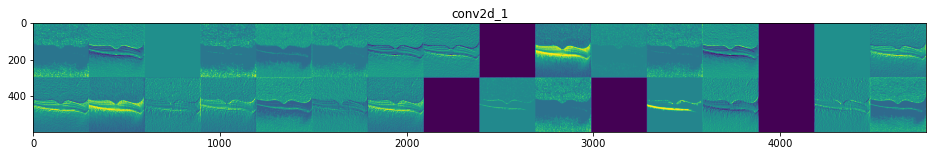

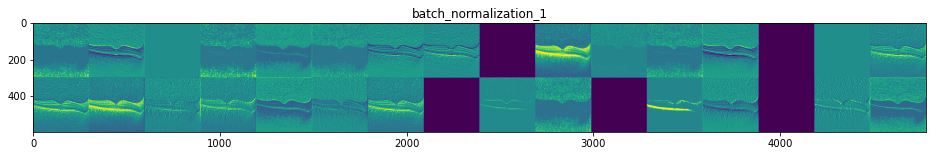

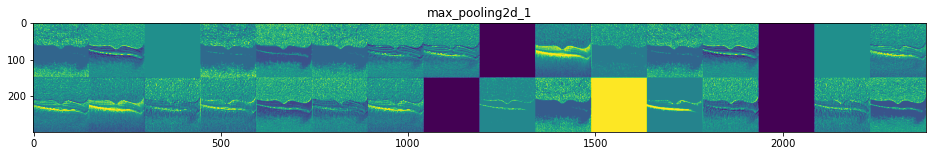

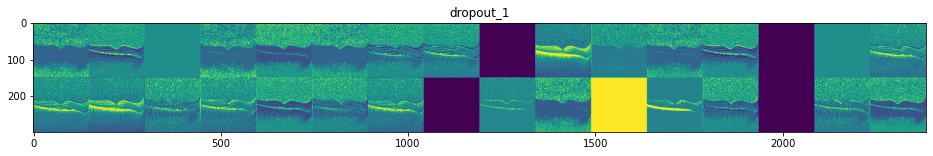

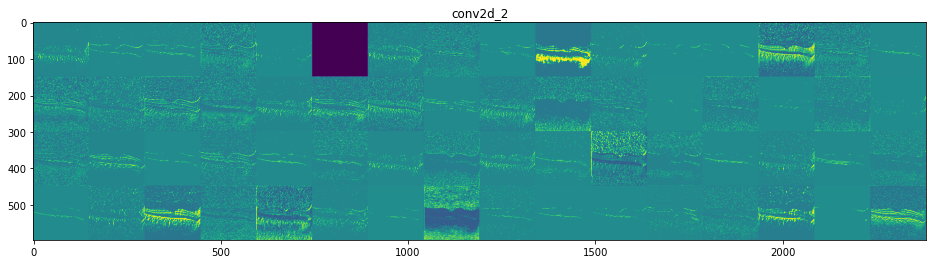

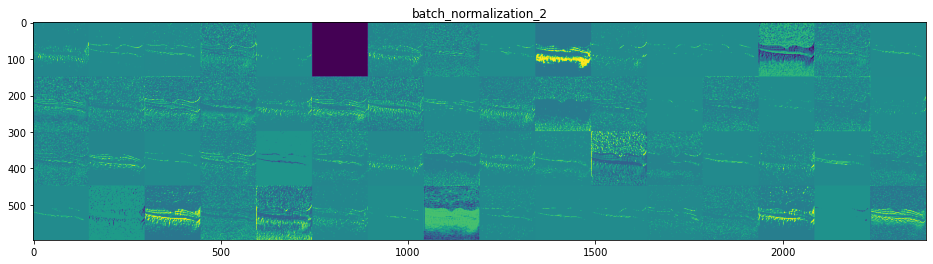

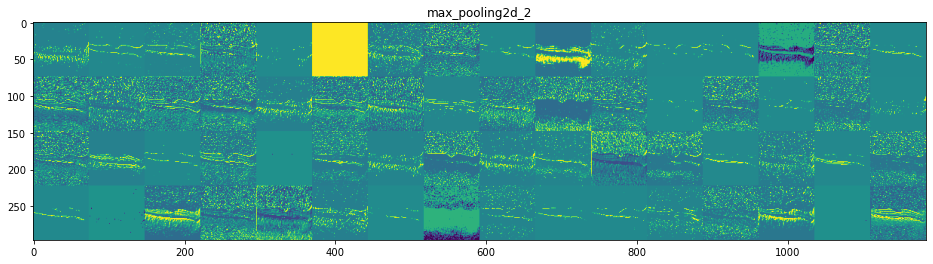

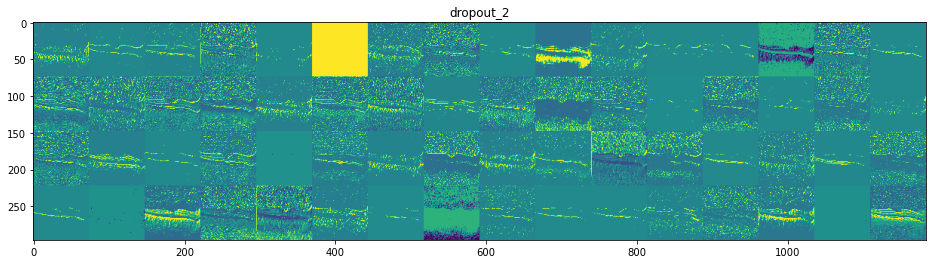

In [34]:
# 층의 이름을 그래프 제목으로 사용하기 위해 생성
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): #  layer이름과 각층의 shape을 하나로.
    n_features = layer_activation.shape[-1] # 특성맵에 있는 특성의 수
    
    size = layer_activation.shape[1] # (1, size, size, n_features)
    
    n_cols = n_features // images_per_row # 나중에 이미지를 출력할 좌표의 행의 개수
    display_grid = np.zeros((size*n_cols, size*images_per_row)) # 특성맵을 출력하기 위한 맵만들기.
    
    for col in range(n_cols): 
        for row in range(images_per_row):
            channel_image = layer_activation[0,:,:,col*images_per_row+row] # 특성맵 하나씩 불러오기
            
            # 그래프로 나타내기 좋게 특성을 처리
            channel_image -= channel_image.mean() # 채널 이미지의 평균값을 빼기
            channel_image /= channel_image.std()  # 채널 이미지의 표준편차로 나누기
            channel_image *= 64 # ?? 
            channel_image += 128 ## ??
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                        row * size : (row + 1) * size] = channel_image # 그리드 출력
    
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                       scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()